In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from config_paths import RESULTS_PATH
import cli_logic as cl
import pandas as pd

results_125 = list(RESULTS_PATH.rglob("*step125.pkl"))
game_id_list = [file.parts[6].split("_")[0] for file in results_125]

all_games = []
for (id, file) in zip(game_id_list, results_125):
    game = cl.load_game(id)
    df_tracking_filtered = cl.filter_tracking_data(game, 1)
    df_frameified = cl.frameify_tracking_data(df_tracking_filtered, game)

    per = (df_frameified.groupby("player_id")["frame"]
           .nunique()
           .rename("frames_alive")
           .reset_index())
    max_frames = per["frames_alive"].max()
    per["minutes_alive_approx"] = round((per["frames_alive"] / max_frames) * 90, 2)
    per["game"] = id
    per = per[per["player_id"] != "ball"]
    per["player_name"] = per["player_id"].apply(game.player_column_id_to_full_name)
    
    all_games.append(per)
 
per_game = pd.concat(all_games)
per_game.head()



,player_id,frames_alive,minutes_alive_approx,game,player_name
0,away_10,40355,82.92,J03WQQ,Marcel Hartel
1,away_11,3446,7.08,J03WQQ,Johannes Eggestein
2,away_13,35727,73.41,J03WQQ,Lukas Stephan Horst Daschner
3,away_14,40355,82.92,J03WQQ,Etienne Amenyido
4,away_19,8074,16.59,J03WQQ,Luca-Milan Zander


In [3]:
player_summary = (
    per_game
    .groupby("player_name", as_index=False)
    .agg(total_frames_alive=("frames_alive","sum"),
         games_with_alive=("game","nunique"),
         total_minutes_alive=("minutes_alive_approx", "sum"),
         avg_minutes_alive=("minutes_alive_approx", "mean"),
         median_minutes_alive=("minutes_alive_approx", "median"),
         max_minutes_alive=("minutes_alive_approx", "max"))
)

player_summary = player_summary.sort_values("total_frames_alive", ascending=False)
player_summary



,player_name,total_frames_alive,games_with_alive,total_minutes_alive,avg_minutes_alive,median_minutes_alive,max_minutes_alive
56,Florian Kastenmeier,203172,5,450.00,90.000,90.00,90.00
118,Matthias Jürgen Zimmermann,203172,5,450.00,90.000,90.00,90.00
31,Dawid Igor Kownacki,184373,5,407.64,81.528,85.94,90.00
22,Christoph Klarer,176097,5,381.17,76.234,90.00,90.00
121,Michal Karbownik,167768,4,360.00,90.000,90.00,90.00
...,...,...,...,...,...,...,...
81,Kaan Caliskaner,1432,1,3.64,3.640,3.64,3.64
20,Christian Viet,1432,1,3.64,3.640,3.64,3.64
162,Vasileios-Konstantinos Lampropoulos,1184,1,3.04,3.040,3.04,3.04
132,Noah Mbamba-Muanda,269,1,0.69,0.690,0.69,0.69


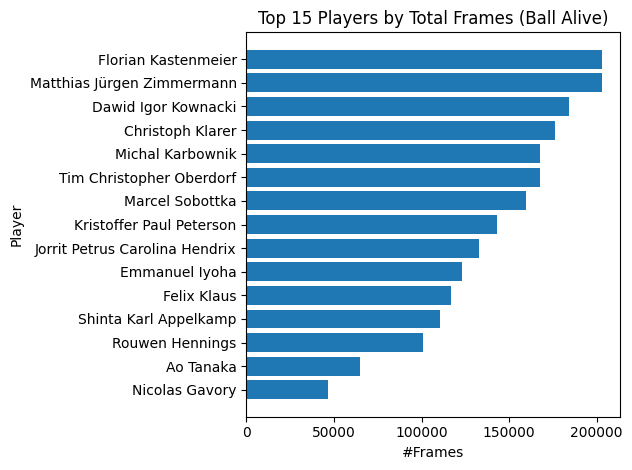

In [4]:
import matplotlib.pyplot as plt
topn = player_summary.nlargest(15, "total_frames_alive")
plt.figure()
plt.barh(topn["player_name"].astype(str), topn["total_frames_alive"])
plt.gca().invert_yaxis()
plt.title("Top 15 Players by Total Frames (Ball Alive)")
plt.xlabel("#Frames")
plt.ylabel("Player")
plt.tight_layout()
plt.show()